<a href="https://colab.research.google.com/github/fxnnxc/Movie_Sentiment_Classification/blob/master/Domain_Specific_Dictionary_by_OLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Specific Dictionary by OLS

* data: movie reviews with sentiment score

In [0]:
import pandas as pd 
import re

data = pd.read_csv('/content/drive/My Drive/MovieSentiment/IMDB Dataset.csv')

In [0]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


## Preprocessing

1. Cleansing
  * remove tags
  * special characters
  * Upper case --> Lower case


2. Stemming 
  * enjoying -> enjoy
  * did -> do

In [0]:
from nltk.stem import PorterStemmer

# Cleansing
def clean_text(string):
  string = re.sub(pattern= '<[^>]*>', repl='', string=string)  # 태그 제거
  string = re.sub(pattern= '[^\w\s]',  repl='', string=string)  # 특수문자 제거
  return string

# Stemming
def stemming_text(string):
  s = PorterStemmer()
  string = string.split()
  string = " ".join([s.stem(w) for w in string])
  return string

# Preprocessing
for i,d in enumerate(data['review']):
  string = d.lower()
  string = clean_text(string)
  #string = stemming_text(string)
  data.iloc[i, 0] =  string


In [0]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [0]:
import re

word_dict = {}

number = 0 
for d in data['review']:
  sent = d.split(' ')
  for w in sent:
      if w in word_dict:
        word_dict[w][1] +=1
      else:
        word_dict[w] = [number, 1]
        number+=1

In [0]:
print(f"unique words: {len(word_dict)}")
print("------------------")
print("WORD  :  COUNT ")
for i in range(5):
  print(list(word_dict.items())[i])
print("------------------")

unique words: 223234
------------------
WORD  :  COUNT 
('one', [0, 50358])
('of', [1, 288060])
('the', [2, 650554])
('other', [3, 17773])
('reviewers', [4, 500])
------------------


In [0]:
LOWER = 300
UPPER = 50005
word_dict2 = {}
number = 0
for w in word_dict:
  if LOWER < word_dict[w][1] < UPPER:
    word_dict2[w] = word_dict[w]
    word_dict2[w][0] = number
    number+=1

In [0]:
for i in range(10):
  print(list(word_dict2.values())[i])

[0, 17773]
[1, 500]
[2, 32881]
[3, 1029]
[4, 14397]
[5, 8920]
[6, 34669]
[7, 2308]
[8, 3039]
[9, 2604]


# Ordinary Least Square

Example of data

 || happy | sad| ... | Good| y|
 |---|---|---|---|---| ---|
 X1| 4 |3|2|0|  0
 X2| 0 |2|5|1| 1
 X3| 2 |3|8|9|   0
 X4| 1 |2|2|1| 0



In [0]:
import numpy as np

def category(v):
  if v =='positive': 
    return 1
  else:
    return 0

y = np.array(list(map(category, data['sentiment'])))
x = np.zeros((len(data), len(word_dict2)))

# Make X
for i, d in enumerate(data['review']):
  sent = d.split(' ')
  for w in sent:
    try:
      x[i][word_dict2[w][0]] +=1   
    except:
      pass

# Normalize
for i in range(x.shape[0]):
  v = sum(x[i,:])
  for j in range(x.shape[1]):
    x[i,j] = x[i,j] / v
print(f"X:{x.shape}")
print(f"y:{y.shape}")

X:(50000, 2911)
y:(50000,)


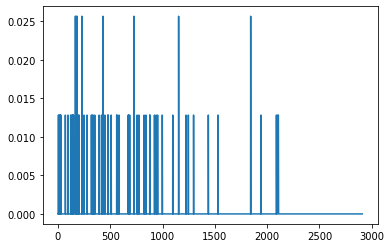

In [0]:
import matplotlib.pyplot as plt
plt.plot(x[100])

In [0]:
A = np.concatenate((x, np.ones((len(x),1))), axis=1) # OLS
m = np.linalg.lstsq(A, y, rcond=None)

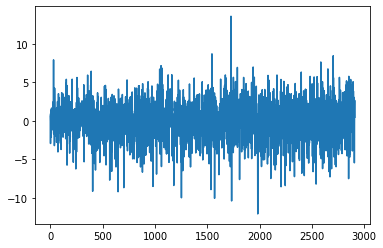

In [0]:
plt.plot(m[0])

In [0]:
for i in range(len(m[0])-2):
  if m[0][i]> 6:
    print(list(word_dict2.keys())[i])

pulls
8
haunting
wonderfully
entertain
refreshing
810
patient
unexpected
subtitles
nevertheless
raw
appreciated


In [0]:
for i in range(len(m[0])):
  if m[0][i]< -8:
    print(list(word_dict2.keys())[i])

mildly
fails
disappointment
clichéd
insult
tedious
credibility
obnoxious
disappointing
unconvincing
forgettable
bland
endless
lacks
mediocre


In [0]:
word_dict2['like']

[244, 38823]

In [0]:
def evaluate1(sent):
  v = 0
  normal = 0
  for w in sent.split(' '):
      if w in word_dict2:
        normal +=1

  for w in sent.split(' '):
    try:
      index = word_dict2[w][0]
      value = word_dict2[w][1]/normal
      v += m[0][index]*value 
    except:
      pass
  return v+ m[0][-1]

In [0]:
for i in range(1,20,2):
  print(i, evaluate1(data['review'][i]), data.loc[i, 'sentiment'])

1 3606.104262378687 positive
3 -473.56102685271003 negative
5 2982.477008089542 positive
7 830.9386294064149 negative
9 864.1679123155493 positive
11 330.61470122186466 negative
13 -1109.4580777205874 negative
15 -1299.654641831774 negative
17 -2992.394846148181 negative
19 -1784.727921313392 negative


In [0]:
data['evaluate'] = 0
for d in range(len(data)):
  data.loc[d, 'evaluate'] = evaluate1(data.loc[d,'review'])

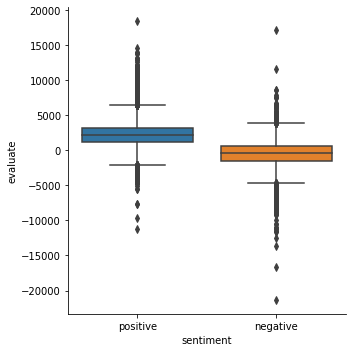

In [0]:
import seaborn as sns

sns.catplot(x="sentiment", y="evaluate", kind="box", data=data)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3,random_state=0)

classifier = LinearSVC(random_state=0, tol=1e-5, verbose=1)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


[LibLinear]

In [0]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(classifier.predict(X_test),y_test)}")

Accuracy: 0.8519333333333333


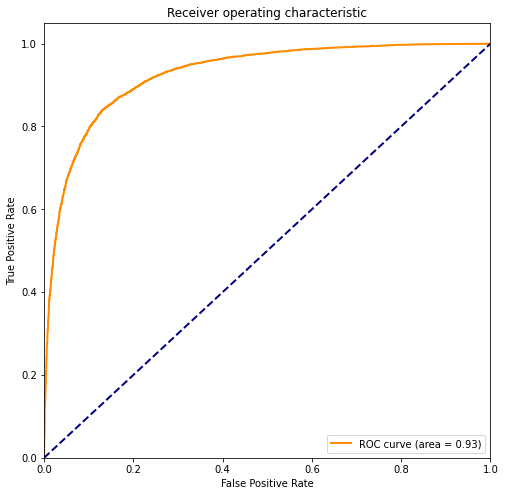

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test[:], y_score[:])
roc_auc = auc(fpr, tpr)


# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Smaller Dictionary 500~ 50000 Frequency

위에서는 300~ 50000 Frequency

In [0]:
LOWER = 500
UPPER = 50005
word_dict3 = {}
number = 0
for w in word_dict:
  if LOWER < word_dict[w][1] < UPPER:
    word_dict3[w] = word_dict[w]
    word_dict3[w][0] = number
    number+=1

In [0]:
import numpy as np

def category(v):
  if v =='positive': 
    return 1
  else:
    return 0

y3 = np.array(list(map(category, data['sentiment'])))
x3 = np.zeros((len(data), len(word_dict3)))

# Make X
for i, d in enumerate(data['review']):
  sent = d.split(' ')
  for w in sent:
    try:
      x3[i][word_dict3[w][0]] +=1   
    except:
      pass

# Normalize
for i in range(x3.shape[0]):
  v = sum(x3[i,:])
  for j in range(x3.shape[1]):
    if v >0:
      x3[i,j] = x3[i,j] / v
print(f"X:{x3.shape}")
print(f"y:{y3.shape}")

X:(50000, 1901)
y:(50000,)


In [0]:
A3 = np.concatenate((x3, np.ones((len(x3),1))), axis=1) # OLS
m3 = np.linalg.lstsq(A3, y3, rcond=None)

In [0]:
def evaluate3(sent):
  v = 0
  normal = 0
  for w in sent.split(' '):
      if w in word_dict3:
        normal +=1

  for w in sent.split(' '):
    try:
      index = word_dict3[w][0]
      value = word_dict3[w][1]/normal
      v += m3[0][index]*value 
    except:
      pass
  return v+ m3[0][-1]

In [0]:
data['evaluate'] = 0
for d in range(len(data)):
  data.loc[d, 'evaluate'] = evaluate3(data.loc[d,'review'])

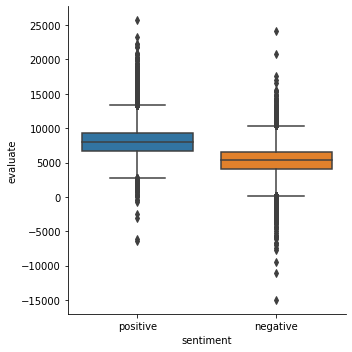

In [0]:
import seaborn as sns

sns.catplot(x="sentiment", y="evaluate", kind="box", data=data)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=.3,random_state=0)

classifier = LinearSVC(random_state=0, tol=1e-5, verbose=1)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


[LibLinear]

In [0]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(classifier.predict(X_test),y_test)}")

Accuracy: 0.8508


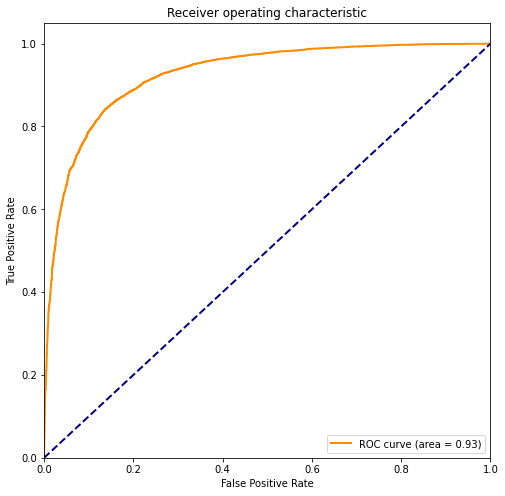

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test[:], y_score[:])
roc_auc = auc(fpr, tpr)



plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()